# First Modeling

Here I'll take my work from the two previous notebooks, and I'll try some simple modeling

In [28]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import wikipedia
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix

### Tidying up

Let's take our data from the 'games_with_plots.csv' file that we exported from the [wikiscraping](./02_wikiscraping.ipynb) notebook

In [3]:
games_with_plots = pd.read_csv('../data/games_with_plots.csv')
games_with_plots.shape

(4196, 19)

Grab just the columns we're interested in for now

In [4]:
important_columns = ['game', 'console', 'publisher', 'developer',
                     'critic_score', 'release_date', 'plots']
gdf = games_with_plots[important_columns]

Put a little text cleaner here for now, i'm not really sure if this is necessary but w/e 

\***move to src folder soon**\*

In [5]:
def clean_text(text):
    import string
    words = [''.join(ch for ch in s if ch not in string.punctuation) for s in text.split()]
    return ' '.join(words).lower()

Let's do some minor data cleaning

In [6]:
gdf.plots = gdf.plots.apply(clean_text)
gdf.release_date = pd.to_datetime(gdf.release_date, errors='coerce')
gdf.critic_score = gdf.critic_score.astype(float)
gdf.sample(5)

game console                     publisher  \
3791            Murder in the Abbey      PC    DreamCatcher Interactive     
2429                Class of Heroes     PSP                       Atlus     
419                   Madden NFL 10     PS3                   EA Sports     
1233                Disney Infinity    WiiU  Disney Interactive Studios     
2687  Bomberman Max 2: Blue Advance     GBA                     Majesco     

                 developer  critic_score release_date  \
3791      Alcachofa Soft             7.0   2008-08-26   
2429             ZeroDiv             5.4   2009-06-09   
419           EA Tiburon             8.5   2009-08-14   
1233  Avalanche Software             7.6   2013-08-18   
2687         Hudson Soft             7.3   2002-05-30   

                                                  plots  
3791  the game is set in the middle ages and its sto...  
2429  players begin the game by selecting characters...  
419   all of the features apply to the ps3 and xbox ...  
1233  disney infinity games are actionadventure game...  
2687  bomberman and max have been shrunk by the evil...

Looking pretty clean, let's go ahead

### Modeling

We'll get our main data split up here

In [7]:
y = gdf[['critic_score']]
X = gdf[['developer', 'plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

Let's vectorize our plots for our first simple model, and let's just start with 1000 features

In [21]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

First model we'll try is just a vanilla Random Forest Regressor

In [22]:
rf = RandomForestRegressor()
rf.fit(X_train_tf, y_train.values.ravel())

RandomForestRegressor()

In [23]:
rf.score(X_test_tf, y_test.values.ravel())

0.3136357461345066

Looks like an FSM score to me....

## New idea: Binning our target

I'm interested in trying to make a simpler model by binning our target variable. First I would like to try just two classifications of critical success, successful or unsuccessful

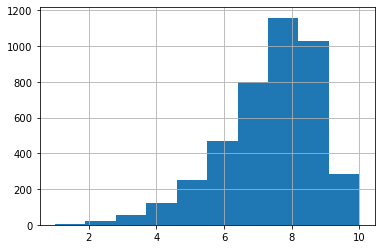

In [24]:
gdf.critic_score.hist();

This left-skewed distribution is typical of reviews, so maybe we should make our first split at 7

In [8]:
gdf['success'] = (gdf['critic_score'] > 7).astype(int)
gdf.head()

game console   publisher       developer  critic_score  \
0         Wii Sports     Wii  Nintendo    Nintendo EAD             7.7   
1  Super Mario Bros.     NES  Nintendo    Nintendo EAD            10.0   
2     Mario Kart Wii     Wii  Nintendo    Nintendo EAD             8.2   
3          Minecraft      PC    Mojang       Mojang AB            10.0   
4  Wii Sports Resort     Wii  Nintendo    Nintendo EAD             8.0   

  release_date                                              plots  success  
0   2006-11-19  wii sports consists of five separate sports ga...        1  
1   1985-10-18  in the fantasy setting of the mushroom kingdom...        1  
2   2008-04-27  mario kart wii is a kart racing game featuring...        1  
3   2010-05-10  minecraft is a 3d sandbox game that has no spe...        1  
4   2009-07-26  wii sports resort is a sports video game set i...        1

In [9]:
gdf.success.value_counts()

1    2636
0    1560
Name: success, dtype: int64

### Modeling again

Let's get going with a classifier model

I'll use SVM as it tends to work well for these text-based things

In [10]:
y = gdf[['success']]
X = gdf[['developer', 'plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

In [24]:
svm = SGDClassifier()
svm.fit(X_train_tf, y_train.values.ravel())

SGDClassifier()

Let's see how our accuracy for our base classifier model does

In [27]:
svm.score(X_test_tf, y_test)

0.6949475691134414

In [29]:
confusion_matrix(y_test, svm.predict(X_test_tf))

array([[205, 189],
       [131, 524]], dtype=int64)

**Not a bad place to start**,  but not great either

Last thing I want to try is a tertiary classification